**Test Environment Notebook**
------

In [1]:
### Tool imports
import joblib as jbl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### sklearn imports
from sklearn.cluster import KMeans, MiniBatchKMeans

### Local imports
import utils.data_handling_lib as dhl
import utils.graphics_lib as gl

from utils.data_handling_lib import RANDOM_STATE

Create raw test dataset

In [2]:
dataset_file_path = "datasets/winequality-combined.csv"
test_raw_data = dhl.load_data(dataset_file_path)

Reduced features test

In [3]:
test_reduced_raw_data = test_raw_data.copy()

test_reduced_raw_data.drop(["free sulfur dioxide", "total sulfur dioxide", "pH", "residual sugar", "sulphates"], axis=1, inplace=True)

Split dataset

In [4]:
train, train_labels, test, test_labels = dhl.strat_split_dataset(test_reduced_raw_data, "quality", 1)

In [5]:
print(train.head())

      fixed acidity  volatile acidity  citric acid  chlorides  density  \
1536            6.1              0.53         0.08      0.077  0.99528   
2750            6.8              0.32         0.18      0.041  0.99590   
4866            5.8              0.23         0.20      0.043  0.99226   
3350            6.7              0.16         0.28      0.046  0.99210   
2611            8.3              0.16         0.48      0.057  0.99430   

      alcohol  color  
1536     10.3      1  
2750      8.9      0  
4866     10.2      0  
3350     11.4      0  
2611     10.3      0  


**Random Forest w/ KMeans Clustering Test**

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
import utils.clustering_tools_lib as ctl

In [8]:

def fit_test_pipeline_1(data, labels):
    rfkc_test_pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=5, random_state=RANDOM_STATE)),
        ("rf_reg", RandomForestRegressor(n_estimators=100, max_features=4))
    ])
    
    rfkc_test_pipeline.fit(data, labels)
    
    return rfkc_test_pipeline

In [9]:
param_grid = dict(kmeans__n_clusters=[10, 100, 1000])
test_1 = fit_test_pipeline_1(train, train_labels)
#grid_search = GridSearchCV(test_1, param_grid=param_grid)

#grid_search.fit(train, train_labels)
#dhl.save_model(grid_search, "GridSearchRFRegTest1")

In [10]:
grid_search = dhl.load_object("models", "GridSearchRFRegTest1")

In [11]:
print(f"\n{grid_search.best_score_}\n{grid_search.best_params_}\n{grid_search.best_estimator_}")


0.1658962773804495
{'kmeans__n_clusters': 1000}
Pipeline(steps=[('kmeans', KMeans(n_clusters=1000, random_state=19)),
                ('rf_reg', RandomForestRegressor(max_features=4))])


In [12]:
#dhl.save_model(grid_search,filename="GridSearchRFRegTest1")

In [13]:
kmeans = KMeans(n_clusters=100)
kmeans.fit(train)

KMeans(n_clusters=100)

In [14]:
train.head()

,fixed acidity,volatile acidity,citric acid,chlorides,density,alcohol,color
1536,6.1,0.53,0.08,0.077,0.99528,10.3,1
2750,6.8,0.32,0.18,0.041,0.99590,8.9,0
4866,5.8,0.23,0.20,0.043,0.99226,10.2,0
3350,6.7,0.16,0.28,0.046,0.99210,11.4,0
2611,8.3,0.16,0.48,0.057,0.99430,10.3,0


In [15]:
#sil_scores_100 = ctl.give_silhouette_scores(train, range_upper=100)
#jbl.dump(sil_scores_100, "exports/misc/sil_scores_100.txt")

sil_scores_100 = jbl.load("exports/misc/sil_scores_100.txt")

['exports/misc/sil_scores_100.txt']

In [16]:
sil_scores_100

[0.33347327520750863,
 0.3952250376338664,
 0.3471786397993216,
 0.31692909058479524,
 0.31511409116180256,
 0.2931915872838805,
 0.295154187746664,
 0.30991388341634335,
 0.29983377078579887,
 0.29368255170772395,
 0.2971674033546985,
 0.306745113033609,
 0.30530978750782706,
 0.30781980409940407,
 0.3060920310353682,
 0.309674249445368,
 0.29480257797005677,
 0.29791820376832623,
 0.2999477778855596,
 0.30124795076795097,
 0.3018983975390844,
 0.29687516321902824,
 0.294744646470934,
 0.29631731727317134,
 0.2946187976055052,
 0.2913584029598098,
 0.2887119820234276,
 0.29324712334785186,
 0.29707371878825,
 0.29354542665436373,
 0.294841667900721,
 0.29664873988523455,
 0.29891451879137376,
 0.29643441925325503,
 0.2944981899170945,
 0.29805216269688906,
 0.29278381704727324,
 0.2908379085662341,
 0.2929228079666813,
 0.2851312385035041,
 0.2870595865500473,
 0.29158409691668763,
 0.28630367579263977,
 0.29314350267433437,
 0.28618145991332933,
 0.2906434554257875,
 0.28347012444054

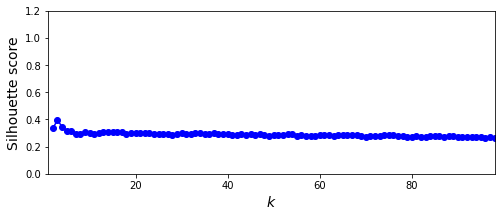

In [17]:
gl.plot_silhouette_scores(sil_scores_100, 100)

In [19]:
sil_scores_15 = ctl.give_silhouette_scores(train, range_upper=15)
#jbl.dump(sil_scores_15, "exports/misc/sil_scores_15.txt")

['exports/misc/sil_scores_15.txt']

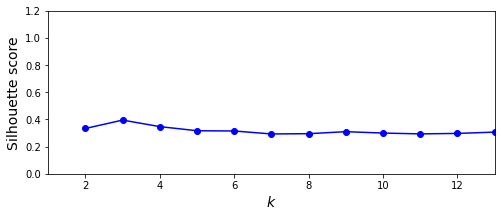

In [21]:
gl.plot_silhouette_scores(sil_scores_15, range_upper=15)